In [1]:
import torch
import torch.nn as nn
# import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
# import torchvision
import torchvision.transforms as transforms
import torch.optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torchnet
import matplotlib.pyplot as plt

import time

DATASET = "fashion_mnist"
TRAINSIZE = 60000
SEED = None
DROPOUT = 0
BATCH_SIZE = 500
DEPTH = 5
WIDTH = 100
OUTPUT_COUNT = 10
LR = 0.002
L1REG = 0.01
MEMORY_SHARE = 0.05
ITERS = 30
EVALUATION_CHECKPOINT = 1
AUGMENTATION = False
SESSION_NAME = "sinusoidal_5_100_KP_{}_{}".format(DROPOUT, time.strftime('%Y%m%d-%H%M%S'))
BN_WEIGHT = 0
COV_WEIGHT = 0
CLASSIFIER_TYPE = "dense"  # "conv" / "dense"
LOG_DIR = "logs/%s" % SESSION_NAME
EVALUATE_USEFULNESS = True
USEFULNESS_EVAL_SET_SIZE = 1000

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

starttime = time.time()

train_dataset = FashionMNIST('.', train=True, download=True,
                             transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = FashionMNIST('.', train=False, download=True,
                            transform=transforms.Compose([transforms.ToTensor()]))
eval_dataset = torch.utils.data.Subset(test_dataset, range(USEFULNESS_EVAL_SET_SIZE))

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

eval_loader = DataLoader(dataset=eval_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

In [2]:
def test_epoch(net, device):
    net.eval()
    correct = 0.
    total = len(test_dataset)

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        # torch.argmax(net(images), dim=1) == labels
        correct += torch.sum(torch.argmax(net(images), dim=1) == labels).cpu().numpy()

    return(correct/total)


def calculate_l1loss(net):
    # l1loss = torch.autograd.Variable(torch.tensor(0, dtype=torch.float, requires_grad=True))
    l1loss = 0.
    for name, param in net.named_parameters():
        if param.requires_grad and 'weight' in name:
            l1loss += torch.mean(torch.abs(param))

    return(l1loss * L1REG)


def get_weights_for_position(pos, net, direction='input'):

    d, p = pos
    weight_layers = []
    for name, weights in net.named_parameters():
        if 'weight' in name:
            weight_layers += [weights.cpu().detach().numpy()]

    return(weight_layers[d][p, :])


def get_grad_for_position(pos, net, direction='input'):

    d, p = pos
    grads = []
    for name, weights in net.named_parameters():
        if 'weight' in name:
            grads += [weights.cpu().detach().numpy()]

    return(grads[d][p, :])


def zero_grad_for_neuron(pos, net, direction='input'):
    d, p = pos
    i = 0
    for name, weights in net.named_parameters():
        if 'weight' in name:
            if i == d:
                # print(weights.grad[p, :].size())
                weights.grad[p, :] = 0
                return()
            i += 1
            

In [3]:
class VanishingDataset(Dataset):
    def __init__(self, list_of_image_target_tuples):
        self.data = torch.stack([x[0] for x in list_of_image_target_tuples])
        self.targets = torch.stack([x[1] for x in list_of_image_target_tuples])
        
    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return(self.data[idx], self.targets[idx])


In [4]:
def get_and_add_topn_activations(net, layer, frozen_neurons, topn, hidden_activations):
    
    hidden_activations_for_layer = np.concatenate([x[layer] for x in hidden_activations], axis=0)
    sum_activations_per_neuron = np.sum(np.abs(hidden_activations_for_layer), axis=0)
    sorted_by_activation = np.argsort(sum_activations_per_neuron)[::-1]
    #print(f'frozen_neurons: {frozen_neurons}')
    old_frozen_neurons = [x[1] for x in frozen_neurons if x[0] == layer]
    #print(f'old frozen: {old_frozen_neurons}')
    new_frozen_neurons = []
    #print(sorted_by_activation)
    for n_i in sorted_by_activation:
        if len(new_frozen_neurons) < topn:
            # print(n_i)
            if n_i in old_frozen_neurons:
                pass
                #print(f'{n_i} is already in frozen neurons')
            else:
                #print(f'{n_i} is not in frozen neurons, adding')
                new_frozen_neurons += [n_i]
        else:
            break
            
    frozen_neurons += [(layer, n_i) for n_i in new_frozen_neurons]
    return(frozen_neurons)

FFNet(
  (fcin): Linear(in_features=784, out_features=100, bias=True)
  (do1): Dropout(p=0, inplace=False)
  (relu1): ReLU()
  (fc_layers): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Dropout(p=0, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): Dropout(p=0, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): Dropout(p=0, inplace=False)
    (8): ReLU()
  )
  (fclass): Linear(in_features=100, out_features=10, bias=True)
)
number of bad guesses: 22829
001/030 Train loss: 1.854    Train accuracy: 0.620    Test accuracy: 0.756	Epoch time: 13.10    L1Loss: 0.002	Weight sum: 3635.123


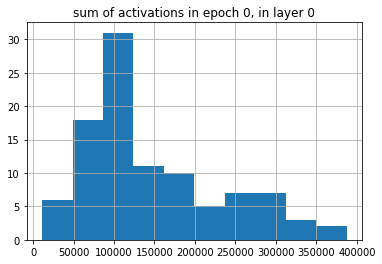

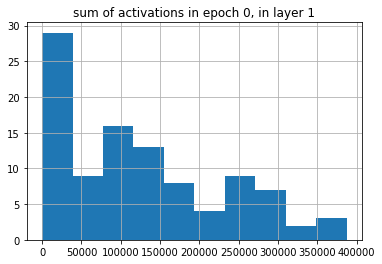

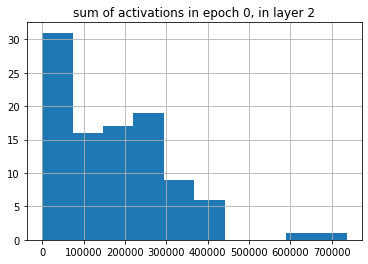

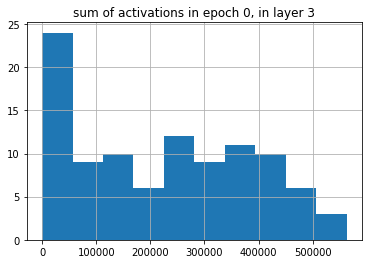

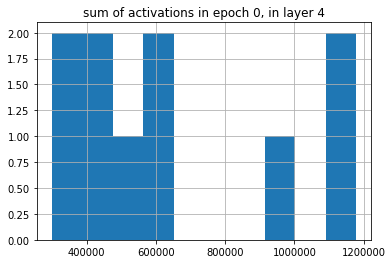

number of bad guesses: 13501
002/030 Train loss: 1.690    Train accuracy: 0.775    Test accuracy: 0.785	Epoch time: 8.77    L1Loss: 0.002	Weight sum: 3949.706


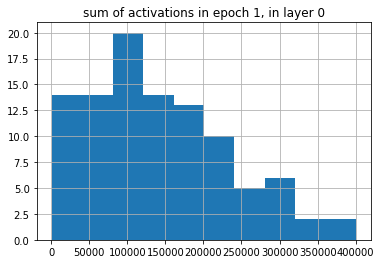

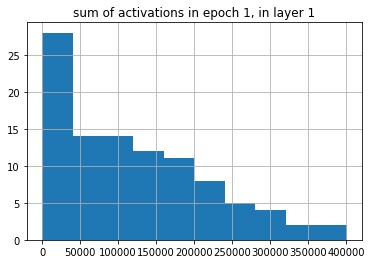

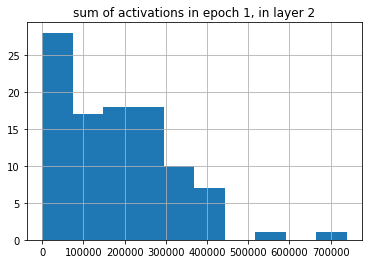

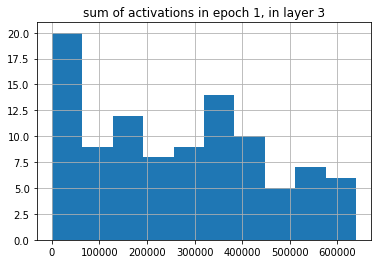

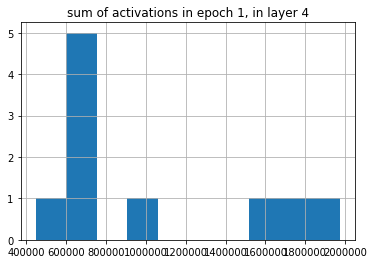

number of bad guesses: 12524
003/030 Train loss: 1.673    Train accuracy: 0.791    Test accuracy: 0.787	Epoch time: 9.24    L1Loss: 0.002	Weight sum: 4199.354


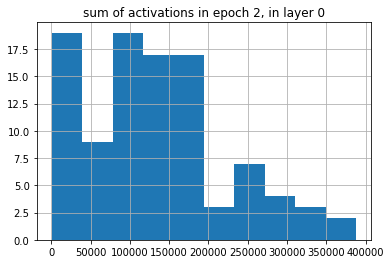

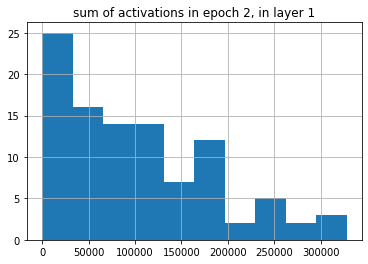

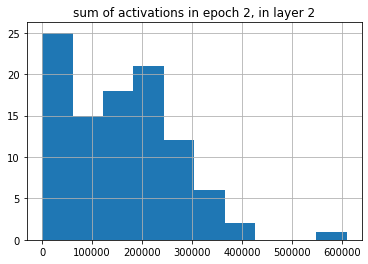

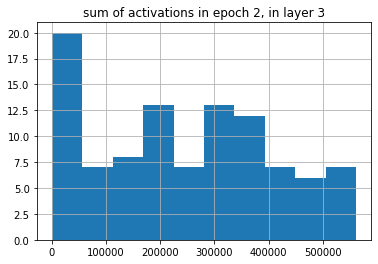

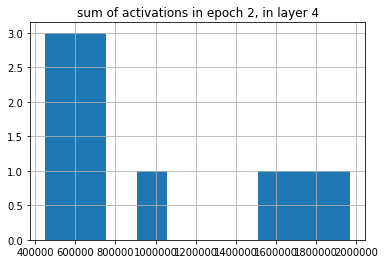

number of bad guesses: 12048
004/030 Train loss: 1.665    Train accuracy: 0.799    Test accuracy: 0.798	Epoch time: 14.71    L1Loss: 0.002	Weight sum: 4395.082


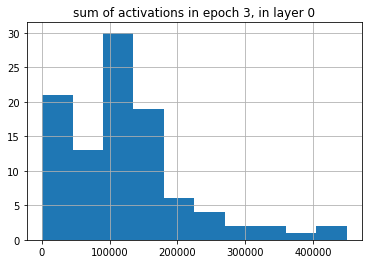

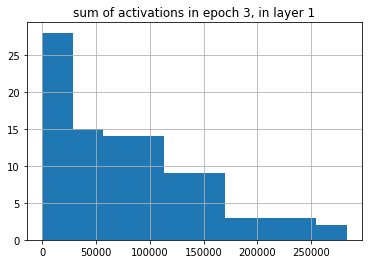

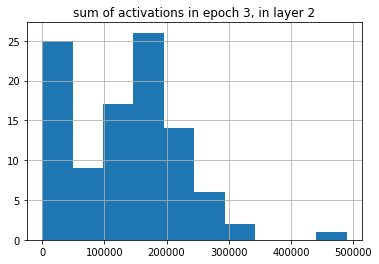

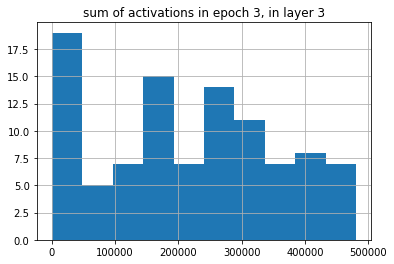

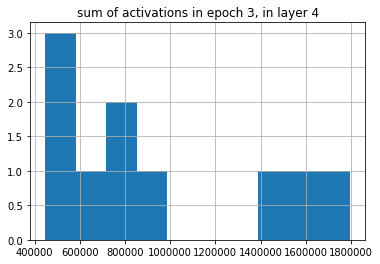

number of bad guesses: 11575
005/030 Train loss: 1.657    Train accuracy: 0.807    Test accuracy: 0.803	Epoch time: 14.35    L1Loss: 0.002	Weight sum: 4551.550


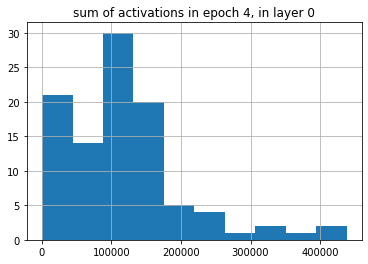

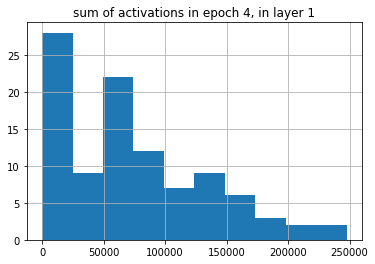

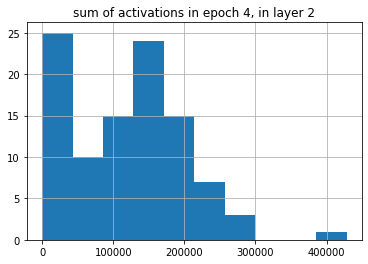

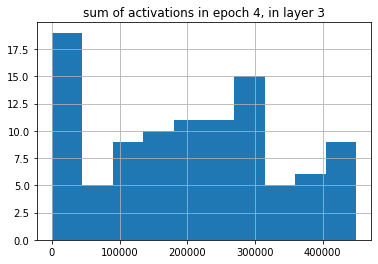

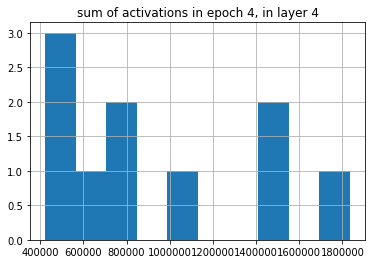

number of bad guesses: 10733
006/030 Train loss: 1.643    Train accuracy: 0.821    Test accuracy: 0.816	Epoch time: 12.41    L1Loss: 0.002	Weight sum: 4842.949


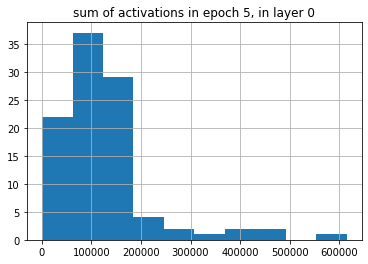

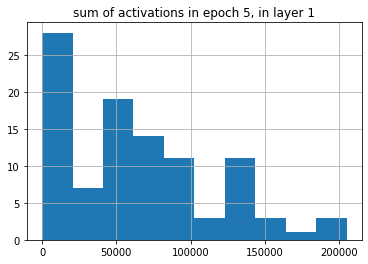

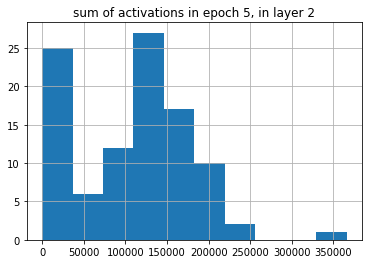

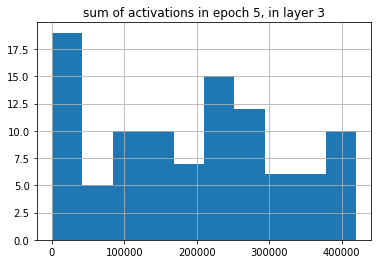

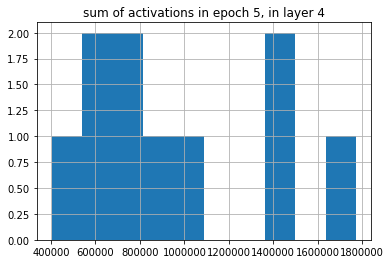

number of bad guesses: 9767
007/030 Train loss: 1.627    Train accuracy: 0.837    Test accuracy: 0.825	Epoch time: 12.03    L1Loss: 0.002	Weight sum: 5080.900


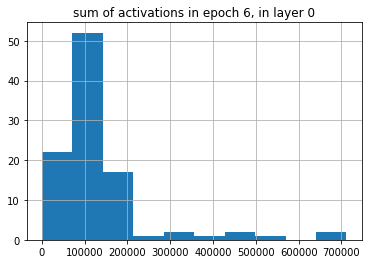

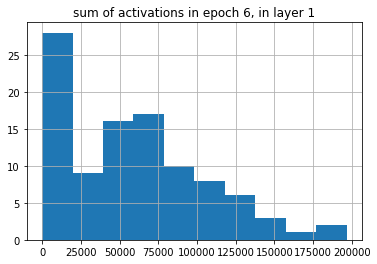

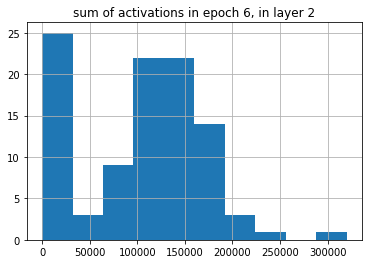

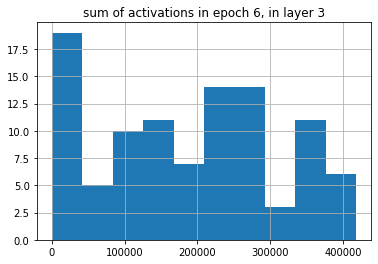

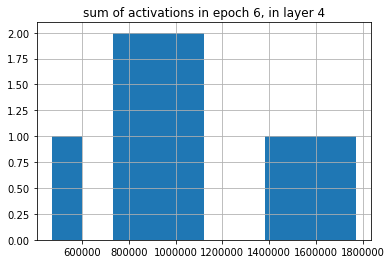

number of bad guesses: 9739
008/030 Train loss: 1.626    Train accuracy: 0.838    Test accuracy: 0.830	Epoch time: 12.97    L1Loss: 0.003	Weight sum: 5327.947


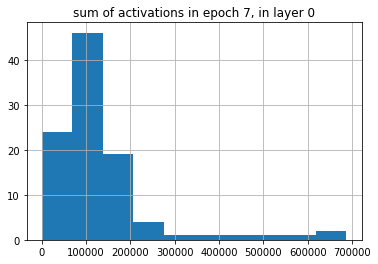

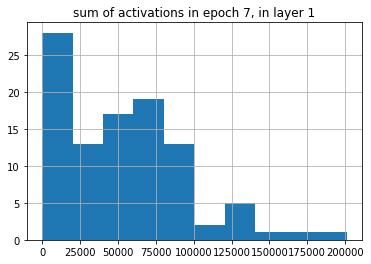

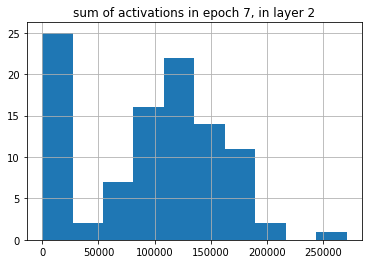

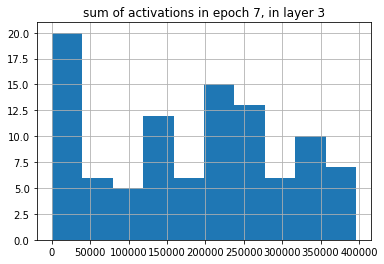

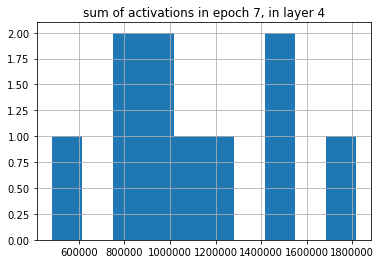

number of bad guesses: 9256
009/030 Train loss: 1.618    Train accuracy: 0.846    Test accuracy: 0.835	Epoch time: 8.72    L1Loss: 0.003	Weight sum: 5527.174


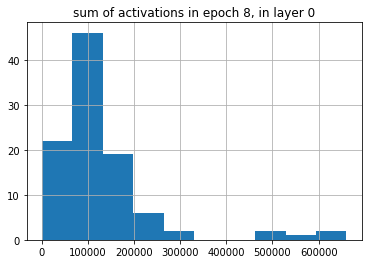

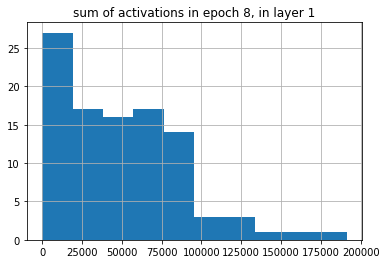

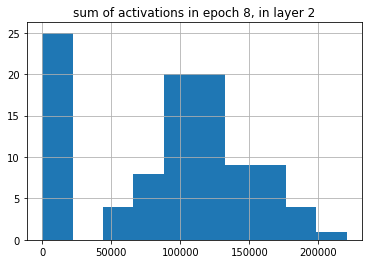

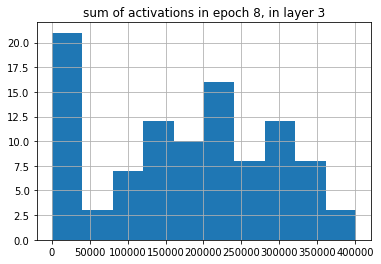

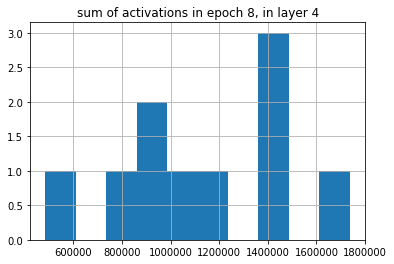

number of bad guesses: 8675
010/030 Train loss: 1.608    Train accuracy: 0.855    Test accuracy: 0.830	Epoch time: 8.51    L1Loss: 0.003	Weight sum: 5700.262


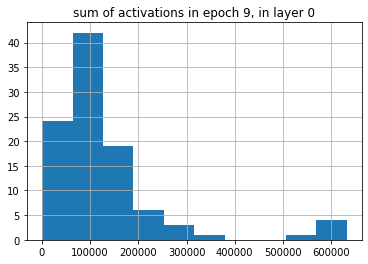

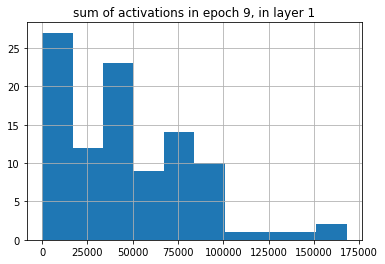

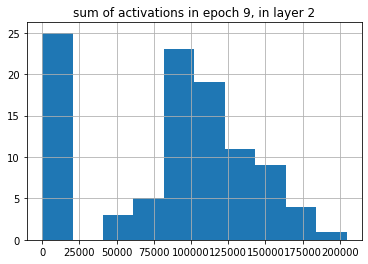

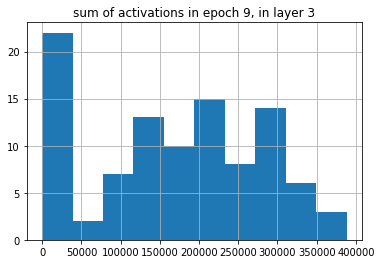

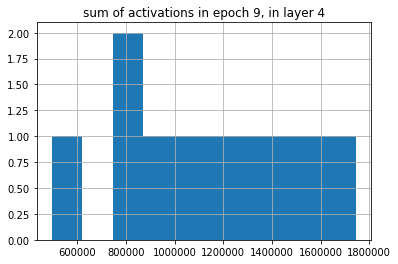

number of bad guesses: 8656
011/030 Train loss: 1.608    Train accuracy: 0.856    Test accuracy: 0.837	Epoch time: 11.15    L1Loss: 0.003	Weight sum: 5876.882


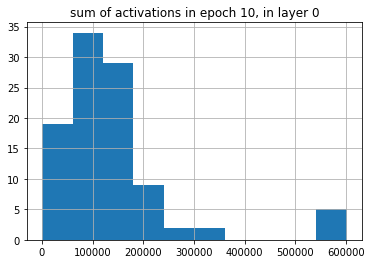

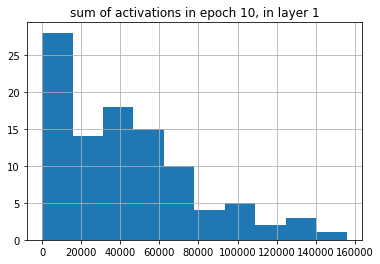

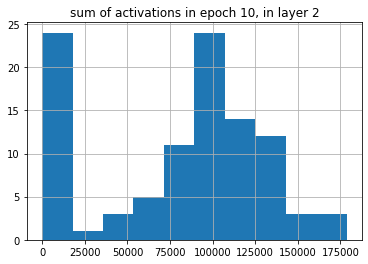

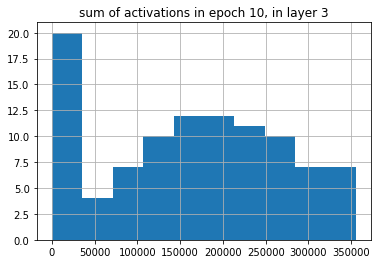

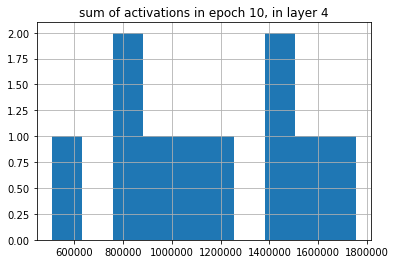

number of bad guesses: 8337
012/030 Train loss: 1.603    Train accuracy: 0.861    Test accuracy: 0.845	Epoch time: 12.23    L1Loss: 0.003	Weight sum: 6026.067


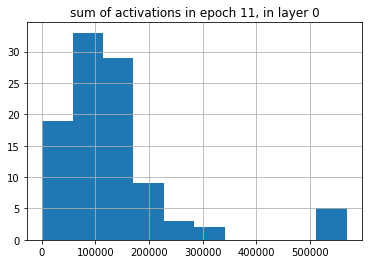

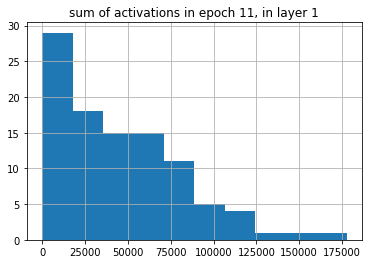

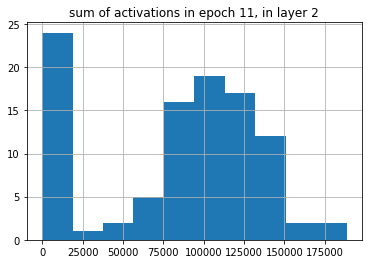

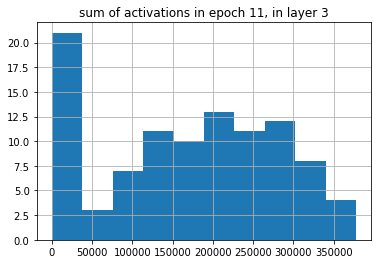

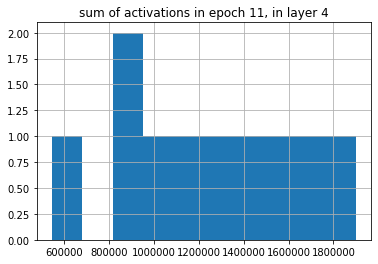

number of bad guesses: 8362
013/030 Train loss: 1.603    Train accuracy: 0.861    Test accuracy: 0.851	Epoch time: 8.45    L1Loss: 0.003	Weight sum: 6252.111


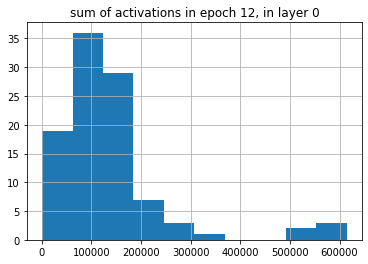

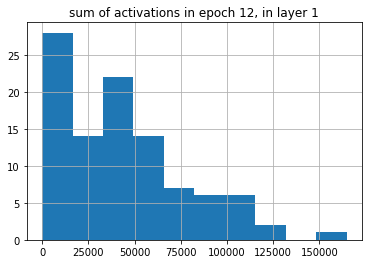

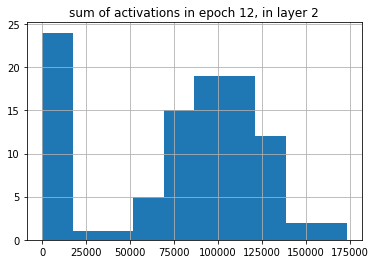

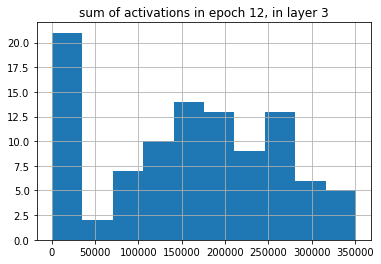

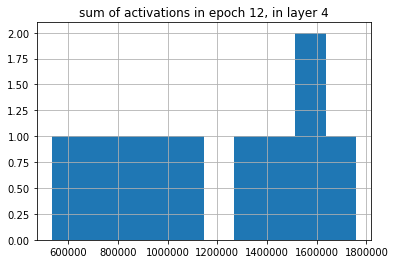

number of bad guesses: 8121
014/030 Train loss: 1.599    Train accuracy: 0.865    Test accuracy: 0.846	Epoch time: 14.48    L1Loss: 0.003	Weight sum: 6388.818


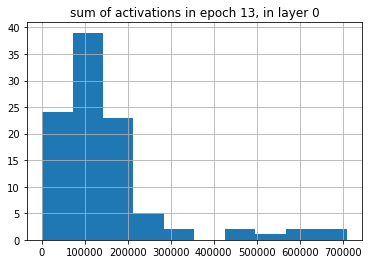

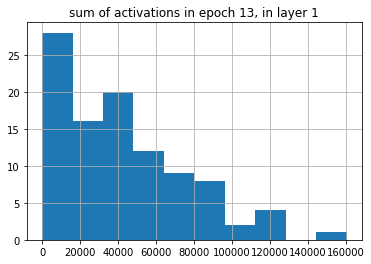

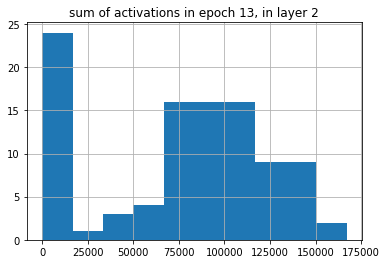

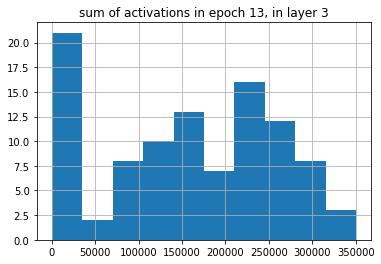

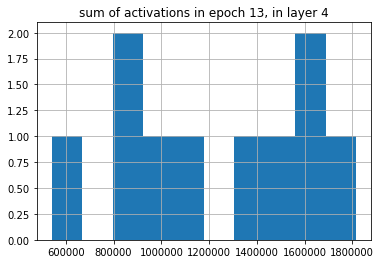

number of bad guesses: 8338
015/030 Train loss: 1.603    Train accuracy: 0.861    Test accuracy: 0.845	Epoch time: 10.38    L1Loss: 0.003	Weight sum: 6557.966


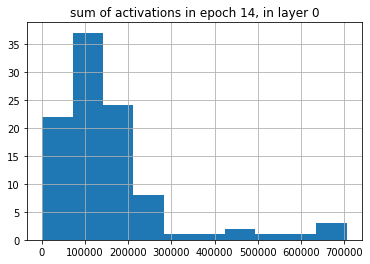

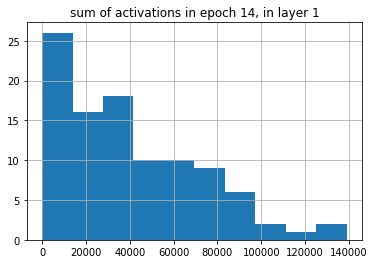

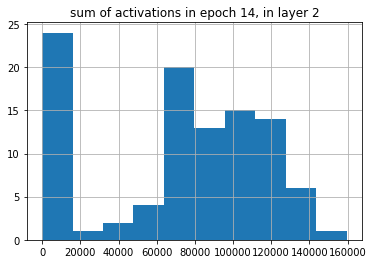

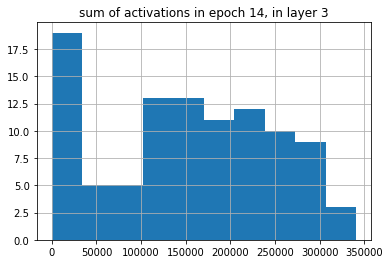

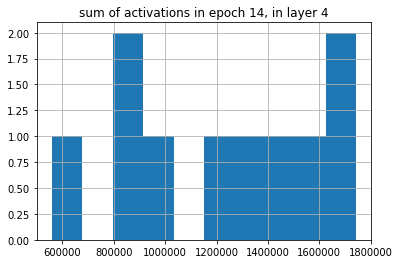

number of bad guesses: 7844
016/030 Train loss: 1.594    Train accuracy: 0.869    Test accuracy: 0.850	Epoch time: 14.22    L1Loss: 0.003	Weight sum: 6671.837
length of the remaining images: 7844
[(0, 3), (0, 82), (0, 90), (0, 39), (0, 10), (0, 17), (0, 83), (0, 29), (0, 49), (0, 23), (0, 80), (0, 52), (0, 73), (0, 41), (0, 43), (0, 62), (0, 25), (0, 72), (0, 44), (0, 77), (0, 81), (0, 60), (0, 95), (0, 40), (0, 51), (0, 11), (0, 5), (0, 94), (0, 9), (0, 48), (0, 97), (0, 65), (0, 92), (0, 89), (0, 28), (0, 1), (0, 91), (0, 56), (0, 20), (0, 96), (0, 50), (0, 46), (0, 54), (0, 0), (0, 85), (0, 35), (0, 38), (0, 75), (0, 21), (0, 69), (0, 30), (0, 74), (0, 66), (0, 45), (0, 76), (0, 37), (0, 19), (0, 78), (0, 67), (0, 4), (0, 36), (0, 33), (0, 71), (0, 61), (0, 79), (0, 7), (0, 16), (0, 63), (0, 47), (0, 6), (0, 86), (0, 84), (0, 70), (0, 13), (0, 26), (0, 87), (0, 15), (0, 31), (0, 42), (0, 8), (0, 53), (0, 55), (0, 58), (0, 93), (0, 24), (0, 68), (0, 99), (0, 12), (0, 32), (0, 59), (0

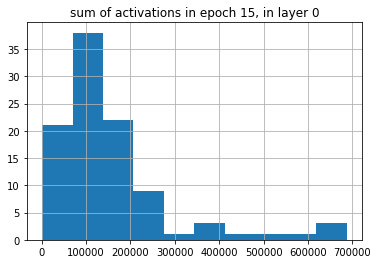

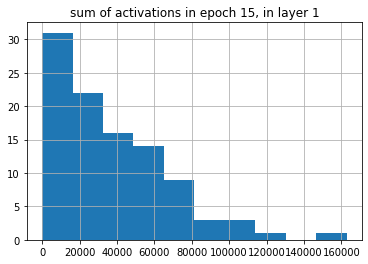

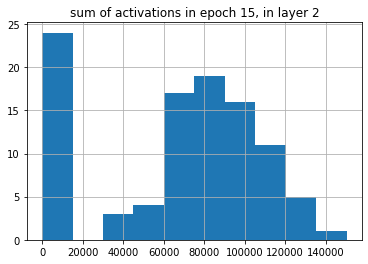

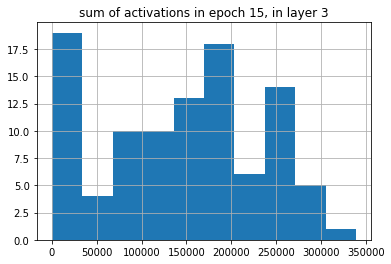

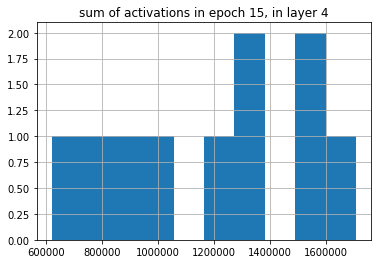

number of bad guesses: 6145
017/030 Train loss: 0.299    Train accuracy: 0.217    Test accuracy: 0.786	Epoch time: 2.31    L1Loss: 0.000	Weight sum: 6703.700


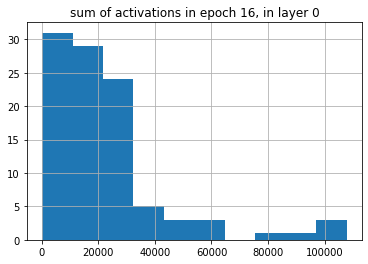

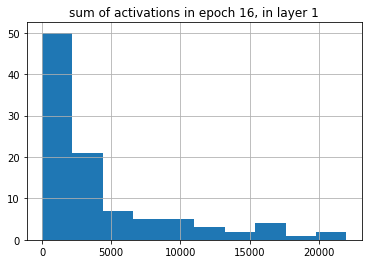

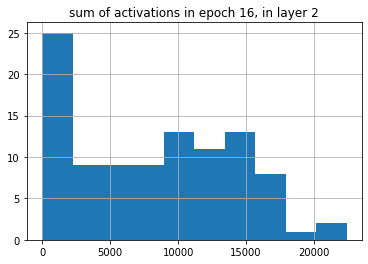

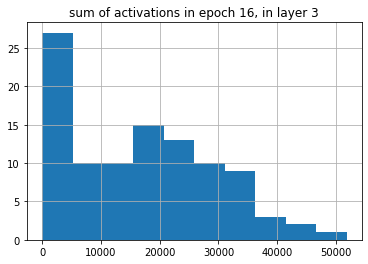

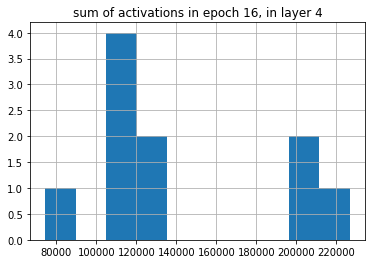

number of bad guesses: 6126
018/030 Train loss: 0.299    Train accuracy: 0.219    Test accuracy: 0.762	Epoch time: 2.40    L1Loss: 0.000	Weight sum: 6709.459


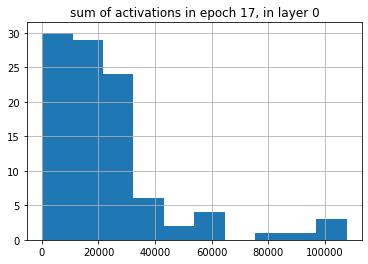

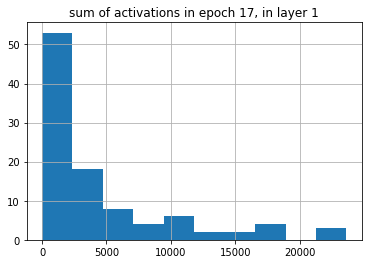

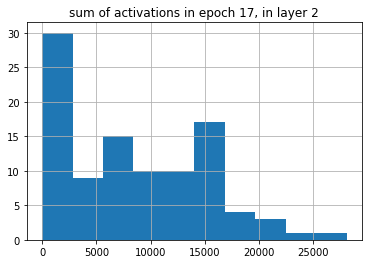

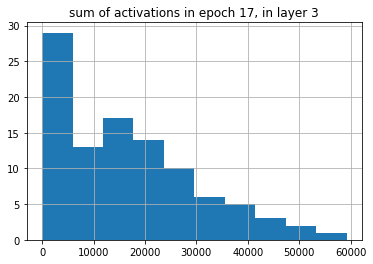

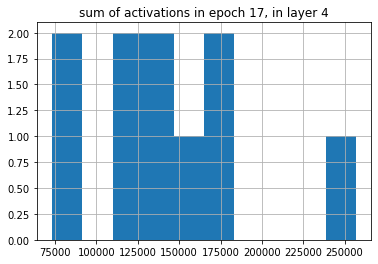

number of bad guesses: 6067
019/030 Train loss: 0.298    Train accuracy: 0.227    Test accuracy: 0.756	Epoch time: 2.31    L1Loss: 0.000	Weight sum: 6712.218


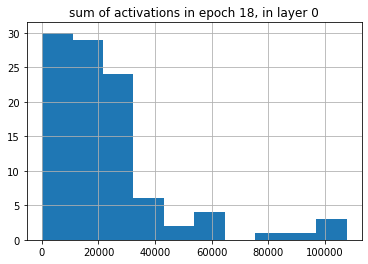

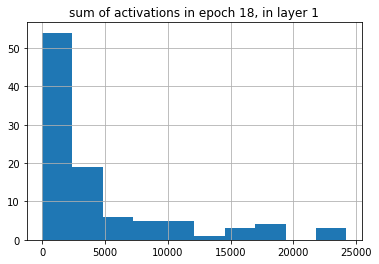

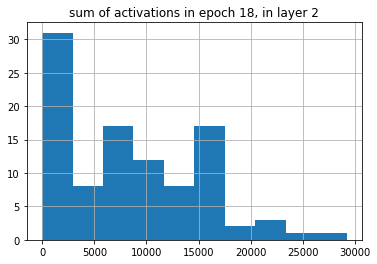

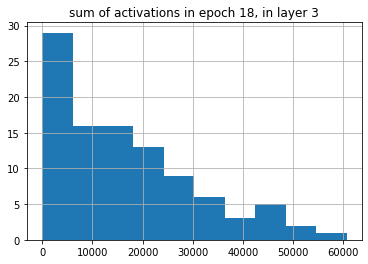

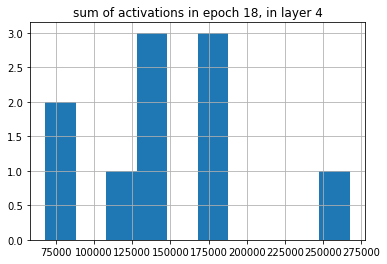

number of bad guesses: 6010
020/030 Train loss: 0.297    Train accuracy: 0.234    Test accuracy: 0.755	Epoch time: 2.22    L1Loss: 0.000	Weight sum: 6714.818


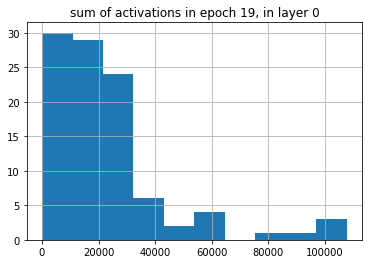

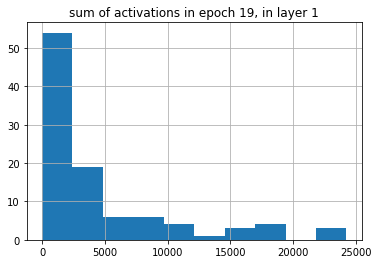

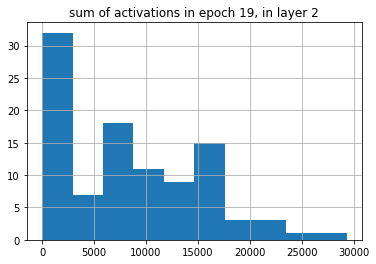

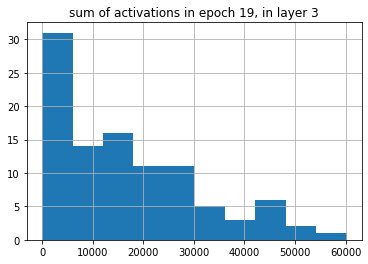

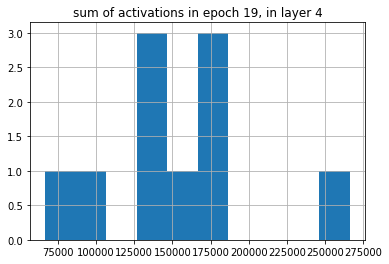

number of bad guesses: 5989
021/030 Train loss: 0.297    Train accuracy: 0.236    Test accuracy: 0.750	Epoch time: 1.51    L1Loss: 0.000	Weight sum: 6717.070


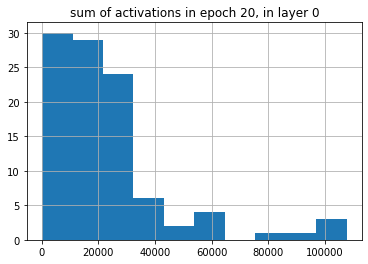

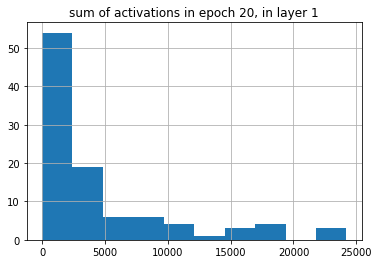

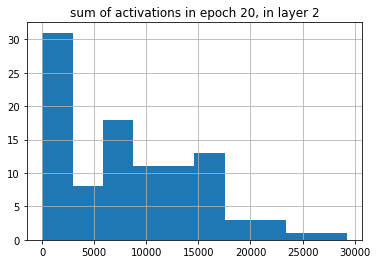

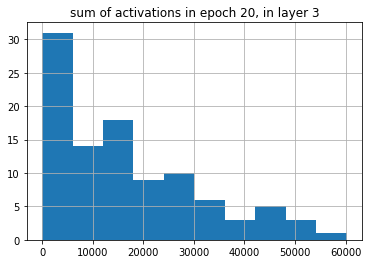

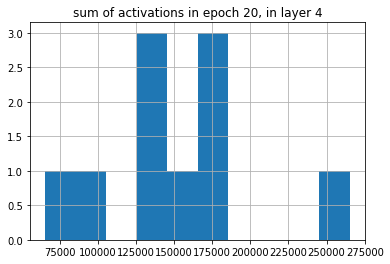

number of bad guesses: 5969
022/030 Train loss: 0.296    Train accuracy: 0.239    Test accuracy: 0.741	Epoch time: 2.18    L1Loss: 0.000	Weight sum: 6719.897


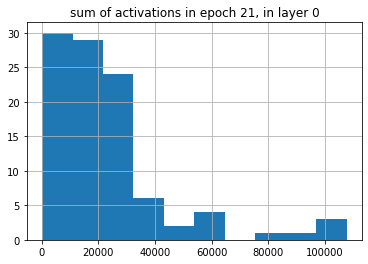

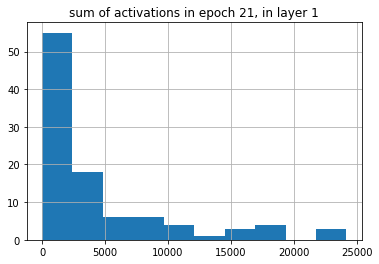

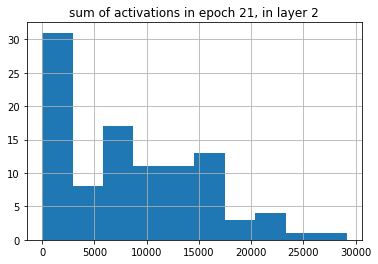

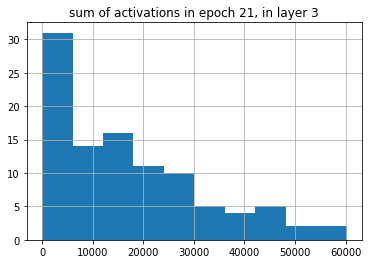

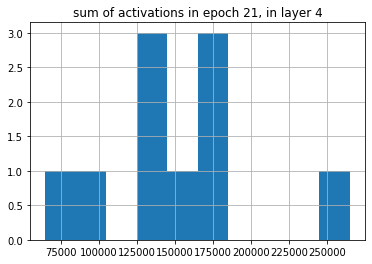

number of bad guesses: 5961
023/030 Train loss: 0.296    Train accuracy: 0.240    Test accuracy: 0.732	Epoch time: 2.11    L1Loss: 0.000	Weight sum: 6722.799


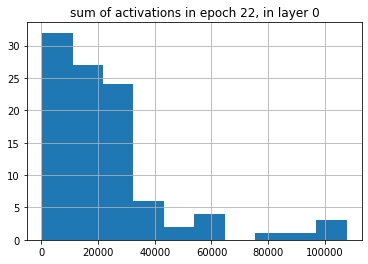

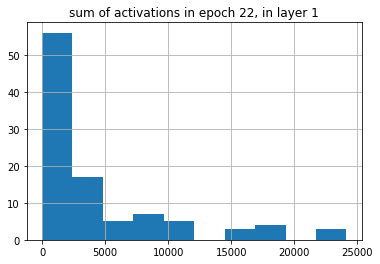

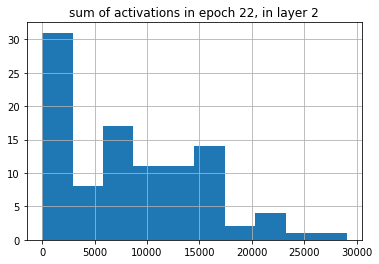

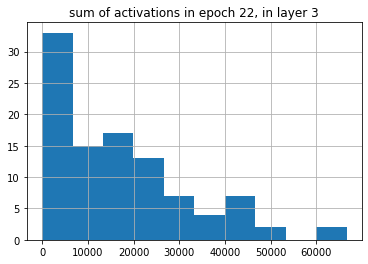

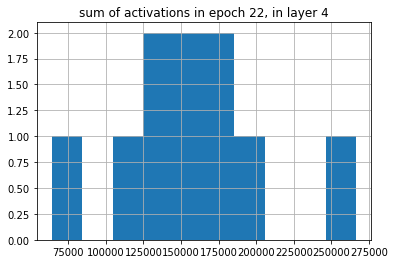

number of bad guesses: 5919
024/030 Train loss: 0.295    Train accuracy: 0.245    Test accuracy: 0.721	Epoch time: 2.06    L1Loss: 0.000	Weight sum: 6725.399


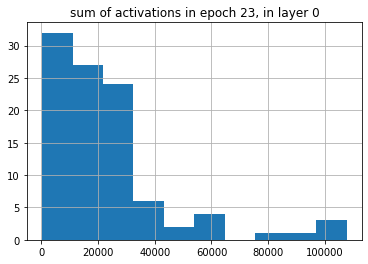

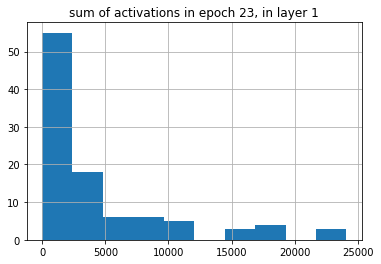

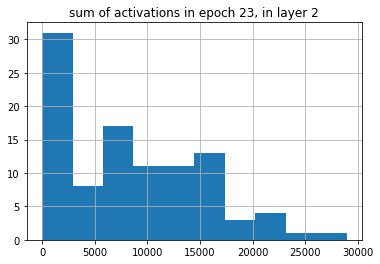

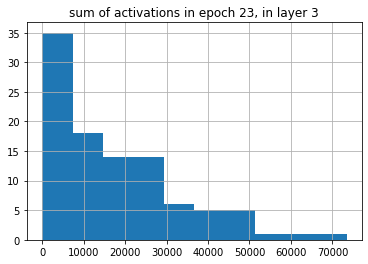

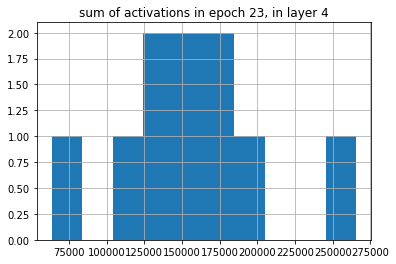

number of bad guesses: 5889
025/030 Train loss: 0.295    Train accuracy: 0.249    Test accuracy: 0.706	Epoch time: 2.03    L1Loss: 0.000	Weight sum: 6727.759


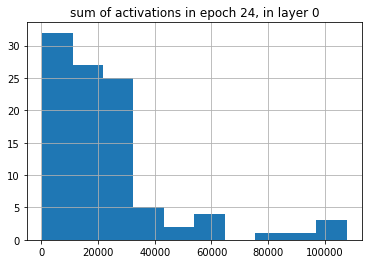

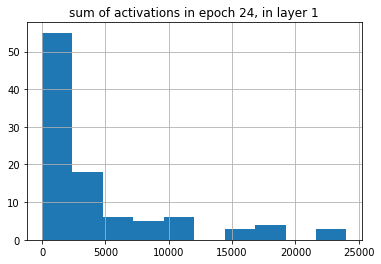

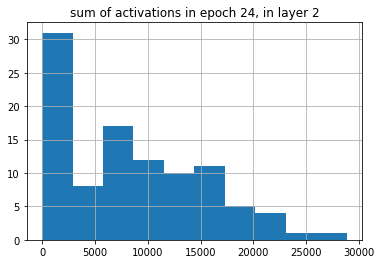

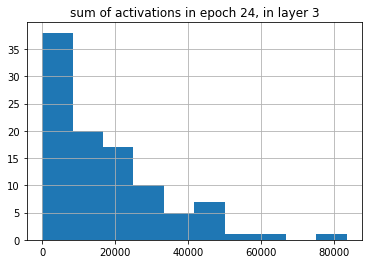

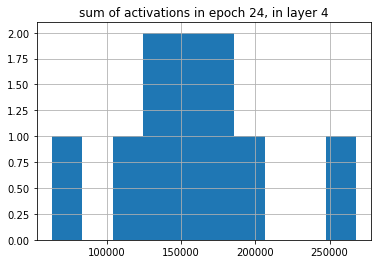

number of bad guesses: 5844
026/030 Train loss: 0.294    Train accuracy: 0.255    Test accuracy: 0.703	Epoch time: 2.15    L1Loss: 0.000	Weight sum: 6730.771


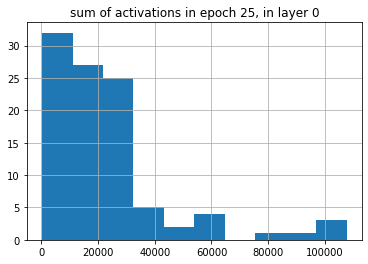

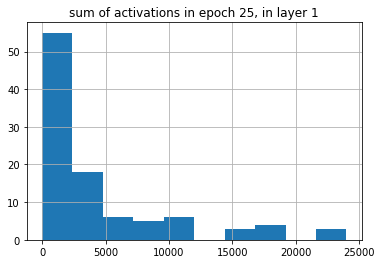

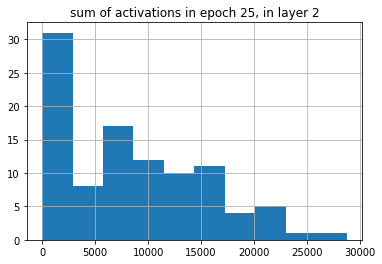

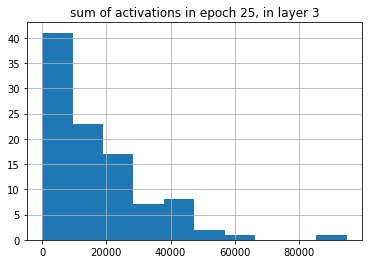

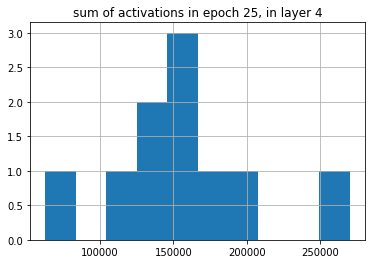

number of bad guesses: 5820
027/030 Train loss: 0.294    Train accuracy: 0.258    Test accuracy: 0.691	Epoch time: 1.50    L1Loss: 0.000	Weight sum: 6733.503


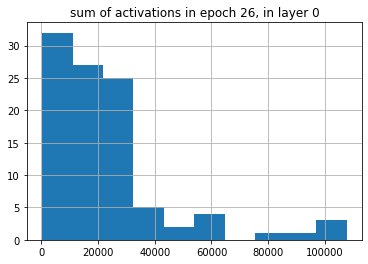

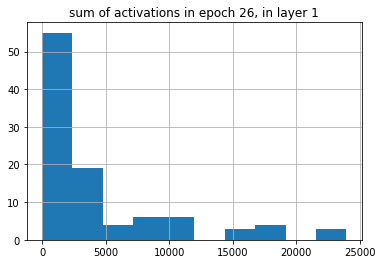

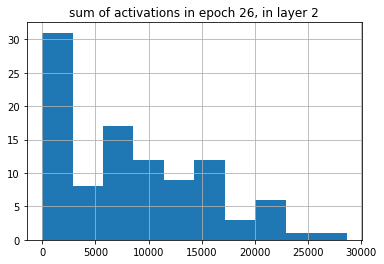

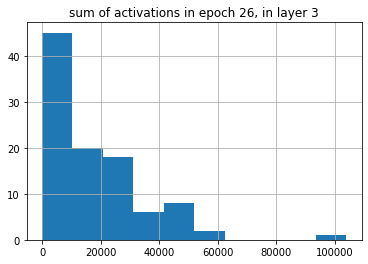

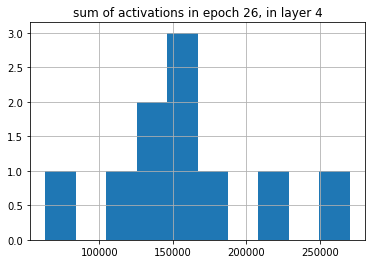

number of bad guesses: 5806
028/030 Train loss: 0.294    Train accuracy: 0.260    Test accuracy: 0.690	Epoch time: 1.50    L1Loss: 0.000	Weight sum: 6736.491


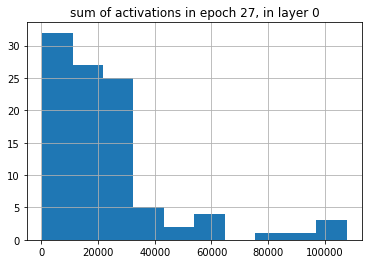

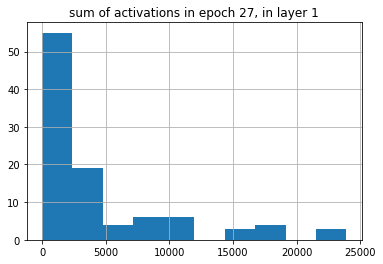

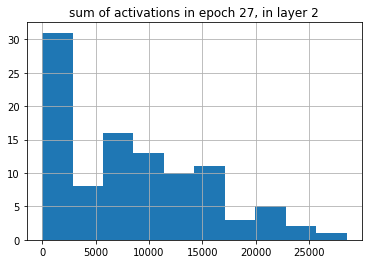

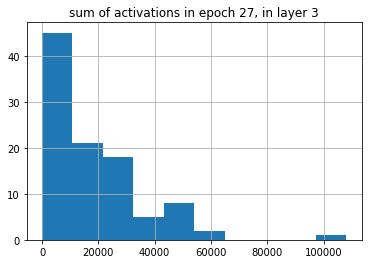

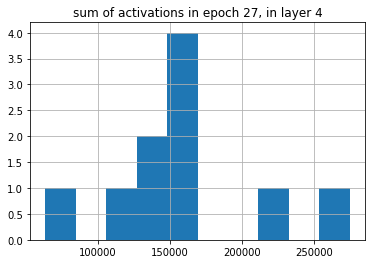

number of bad guesses: 5790
029/030 Train loss: 0.294    Train accuracy: 0.262    Test accuracy: 0.686	Epoch time: 2.03    L1Loss: 0.000	Weight sum: 6738.943


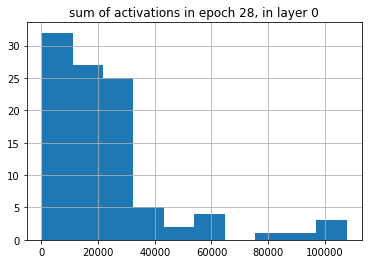

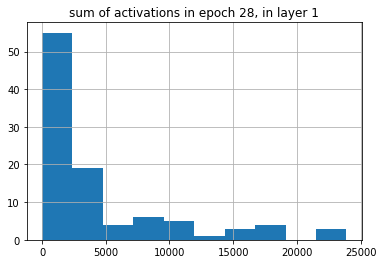

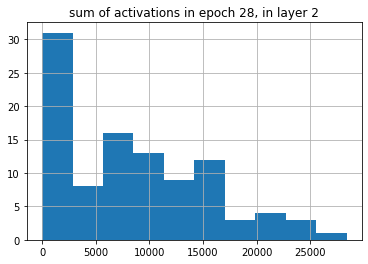

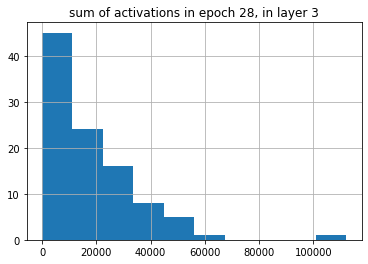

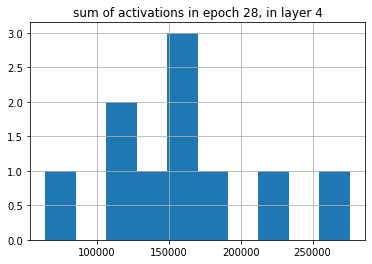

number of bad guesses: 5782
030/030 Train loss: 0.294    Train accuracy: 0.263    Test accuracy: 0.685	Epoch time: 2.02    L1Loss: 0.000	Weight sum: 6741.593


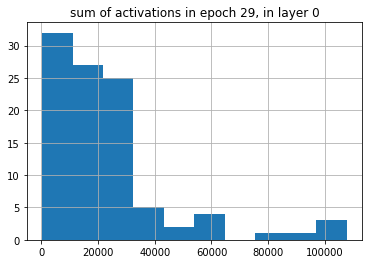

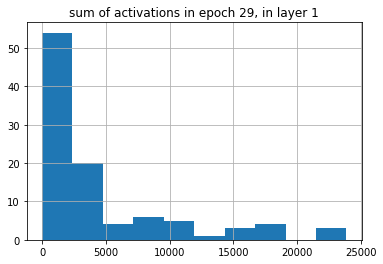

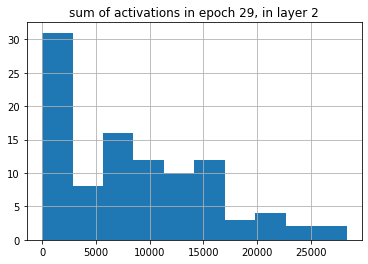

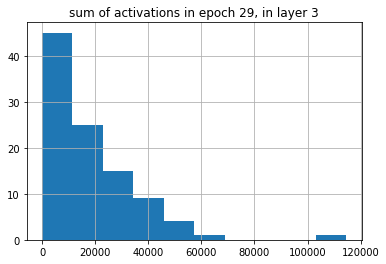

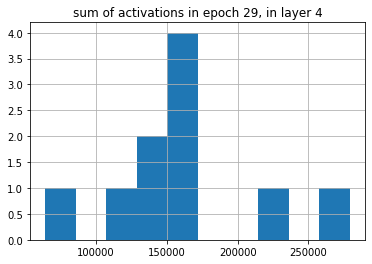

Training took 243.74 seconds


In [5]:
net = torchnet.FFNet(WIDTH, DEPTH, DROPOUT, OUTPUT_COUNT)
net.to(device)

print(net)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LR, weight_decay=0)

minibatches = len(train_dataset) // BATCH_SIZE

neurons_to_freeze = []
vanish_dataloader = train_loader

for epoch in range(ITERS):  # loop over the dataset multiple times
    running_predictions = 0.
    running_loss = 0.0
    running_l1loss = 0.0
    hidden_activations_for_epoch = []
    epochtime = time.time()
    net = net.train()
    samples_seen = 0
    
    
    
        
    list_of_data = []    
    
    for i, data in enumerate(vanish_dataloader, 0):
        
        
            
        # get the inputs; data is a list of [inputs, labels]
        images, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(images)
        
        
        predictions = torch.argmax(outputs, dim = 1)
        for j in range(data[0].shape[0]):
            im, tag, pred = data[0][j].squeeze(), data[1][j].squeeze(), predictions[j]
            if tag != pred:
                list_of_data += [tuple([im, tag])]
        
        
            
        hidden_activations_for_epoch += [net.hidden_activations]
        # l1loss = calculate_l1loss(net)
        l1loss = calculate_l1loss(net)
        loss = criterion(outputs, labels) + l1loss

        running_l1loss += l1loss
        loss.backward()
        # we have the gradients at this point, and they are encoded in param.grad where param is net.parameters()
        if epoch >= 0:
            for pos in neurons_to_freeze:
                zero_grad_for_neuron(pos, net)

        optimizer.step()
        # print statistics
        running_loss += loss
        running_predictions += torch.sum(torch.argmax(outputs, dim=1) == labels).cpu().numpy()
        samples_seen += images.shape[0]
        
    #  = (0, 5)
    # print(np.sum(np.abs(get_weights_for_position(pos, net))))
    print(f'number of bad guesses: {len(list_of_data)}')
    
    print(f'{epoch + 1:03d}/{ITERS:03d} Train loss: {running_loss.cpu() / minibatches:.3f}\
    Train accuracy: {running_predictions/samples_seen:.3f}\
    Test accuracy: {test_epoch(net, device):.3f}\tEpoch time: {time.time()-epochtime:.2f}\
    L1Loss: {running_l1loss.cpu() / minibatches:.3f}\tWeight sum: {sum([p.abs().sum() for p in net.parameters()]):.3f}')
    
    layer=1
    
    ratio_to_freeze = 0.949
    
    if epoch == 15:
        vanishing_dataset = VanishingDataset(list_of_data)
        vanish_dataloader = DataLoader(dataset=vanishing_dataset, batch_size = BATCH_SIZE, shuffle=True)
        
        neurons_to_freeze = get_and_add_topn_activations(net, 0, neurons_to_freeze, int(28*28*ratio_to_freeze), hidden_activations_for_epoch)
        neurons_to_freeze = get_and_add_topn_activations(net, DEPTH-1, neurons_to_freeze, int(OUTPUT_COUNT*ratio_to_freeze), hidden_activations_for_epoch)
        for l in range(1, DEPTH-1):
            topn = int(WIDTH * ratio_to_freeze)
            neurons_to_freeze = get_and_add_topn_activations(net, l, neurons_to_freeze, topn, hidden_activations_for_epoch)
            
            
        neurons_to_freeze = sorted(neurons_to_freeze, key = lambda x: x[0])
        print(f'length of the remaining images: {len(vanishing_dataset)}')
        print(neurons_to_freeze)
    
    
    
    if True:
        for layer in range(DEPTH):
            hidden_activations_for_layer = np.concatenate([x[layer] for x in hidden_activations_for_epoch], axis=0)
            plt.plot(figsize = (12, 6), facecolor = 'w')
            plt.hist(np.sum(np.abs(hidden_activations_for_layer), axis=0))
            plt.title(f'sum of activations in epoch {epoch}, in layer {layer}')
            plt.grid()
            plt.show()


endtime = time.time()
print(f'Training took {endtime-starttime:.2f} seconds')

In [67]:
ims = [x[0] for x in list_of_data]
lbls = [x[1] for x in list_of_data]
ims = torch.stack(ims)
lbls = torch.stack(lbls)
print(ims.shape, lbls.shape)

torch.Size([34000, 28, 28]) torch.Size([34000])


['_DataLoader__initialized',
 '_DataLoader__multiprocessing_context',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_collation',
 '_index_sampler',
 'batch_sampler',
 'batch_size',
 'collate_fn',
 'dataset',
 'dataset_kind',
 'drop_last',
 'multiprocessing_context',
 'num_workers',
 'pin_memory',
 'sampler',
 'timeout',
 'worker_init_fn']

In [30]:
help(FashionMNIST)

Help on class FashionMNIST in module torchvision.datasets.mnist:

class FashionMNIST(MNIST)
 |  FashionMNIST(root, train=True, transform=None, target_transform=None, download=False)
 |  
 |  `Fashion-MNIST <https://github.com/zalandoresearch/fashion-mnist>`_ Dataset.
 |  
 |  Args:
 |      root (string): Root directory of dataset where ``Fashion-MNIST/processed/training.pt``
 |          and  ``Fashion-MNIST/processed/test.pt`` exist.
 |      train (bool, optional): If True, creates dataset from ``training.pt``,
 |          otherwise from ``test.pt``.
 |      download (bool, optional): If true, downloads the dataset from the internet and
 |          puts it in root directory. If dataset is already downloaded, it is not
 |          downloaded again.
 |      transform (callable, optional): A function/transform that  takes in an PIL image
 |          and returns a transformed version. E.g, ``transforms.RandomCrop``
 |      target_transform (callable, optional): A function/transform that ta